In [1]:
from typing import Any

import lightning.pytorch as pl
import torch
from lightning.pytorch.callbacks import ModelCheckpoint
import mlflow
from torch.utils.data import DataLoader, Dataset

from src.ml.data.splitting import create_data_splits
from src.ml.modeling import (
    model_factory,
    optimizer_factory,
)
from src.ml.utils.set_seed import set_seed

from datetime import datetime
from loguru import logger
from pathlib import Path
from shutil import copy, copytree, rmtree

import yaml

from src.ml.train_neural_network import train_neural_network
from src.ml.data import data_sets_factory
from src.ml.preprocessing import preprocessing_factory
from src.ml.utils.set_seed import set_seed

In [2]:
CONFIG_FILE = Path("src/ml/config.yaml")

In [3]:
torch.set_default_device(torch.device("cpu"))

In [4]:
# load config file

logger.info("Loading config file.")

with open(CONFIG_FILE, "r") as f:
    config = yaml.safe_load(f)

2025-01-08 17:04:03.063 | INFO     | __main__:<module>:3 - Loading config file.


In [5]:
# load data

logger.info("Loading data.")

_, data_sets = next(iter(data_sets_factory(**config["data_set"])))

# preprocess data

logger.info("Start preprocessing.")

for preprocessing_step in config["preprocessing"]:
    logger.info("Perform {} preprocessing.", preprocessing_step["name"])

    transform = preprocessing_factory(**preprocessing_step)
    data_sets = transform(data_sets)

dataset = data_sets

2025-01-08 17:04:03.070 | INFO     | __main__:<module>:3 - Loading data.
2025-01-08 17:04:10.969 | INFO     | __main__:<module>:9 - Start preprocessing.
2025-01-08 17:04:10.970 | INFO     | __main__:<module>:12 - Perform add_taxa_names preprocessing.
2025-01-08 17:04:11.927 | INFO     | __main__:<module>:12 - Perform add_relative_clade_information preprocessing.
2025-01-08 17:04:13.523 | INFO     | __main__:<module>:12 - Perform remove_tree preprocessing.


In [6]:
train_dataset, val_dataset, test_dataset = create_data_splits(
    dataset, **config["training"]["splitting_config"]
)

In [7]:
train_loader = DataLoader(train_dataset, **config["training"]["dataloader_config"])
test_loader = DataLoader(test_dataset,batch_size=2)
val_loader = DataLoader(val_dataset, batch_size=128)

optimizer = optimizer_factory(**config["training"]["optimizer_config"])
model = model_factory(
    optimizer=optimizer,
    input_example=train_dataset[0],
    **config["training"]["model_config"],
)

In [8]:
from src.ml.modeling.weight_sharing_tree_flow import WeightSharingTreeFlow

model = WeightSharingTreeFlow.load_from_checkpoint("ml_data/models/yule_10_simple_weight_sharing_fraction_encoding_2025_01_08_17_00_34/yule-10_140/epoch=17-val_loss=25.02.ckpt")
model = model.eval()

<Axes: >

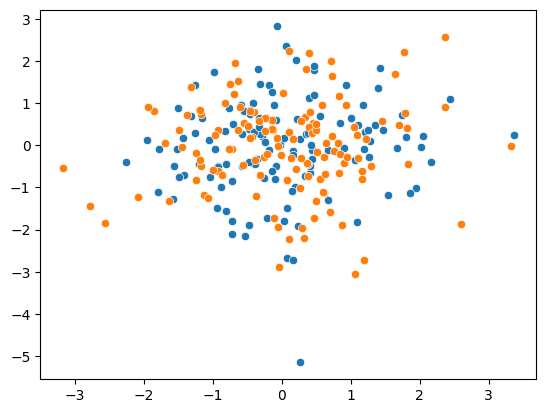

In [9]:
import seaborn as sns
sample = next(iter(val_loader))
latent_space = model.forward(sample)["z"].detach().numpy()
sns.scatterplot(x=latent_space[:, -2], y=latent_space[:, -1])

prior_latent_space = model.prior.sample((128, 2,)).detach().numpy()
sns.scatterplot(x=prior_latent_space[:, 0], y=prior_latent_space[:, 1])

In [16]:
latent = model.forward(sample)
output = model.inverse(latent)

In [20]:
sample["branch_lengths"][0], output["branch_lengths"][0]

(tensor([1.7367e-01, 6.0198e-01, 2.9673e-02, 2.8269e-01, 6.8822e-01, 9.0598e-01,
         6.4103e-01, 9.4204e-01, 1.0000e-06]),
 tensor([1.7367e-01, 6.0198e-01, 2.9673e-02, 2.8269e-01, 6.8822e-01, 9.0598e-01,
         6.4103e-01, 9.4204e-01, 1.0000e-06], grad_fn=<SelectBackward0>))

<Axes: ylabel='Count'>

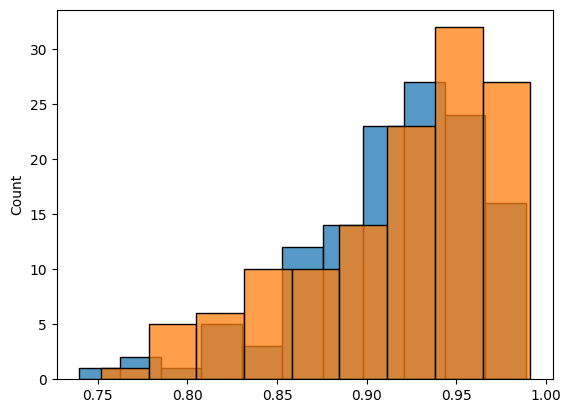

In [36]:
import matplotlib.pyplot as plt
prior = model.prior.sample((128, 63,))
latent = model.forward(sample)
rs = model.inverse(latent)["branch_lengths"]
rs = rs.detach().numpy()
sns.histplot(rs[:, 7])

prior = model.prior.sample((128, 63,))
latent = model.forward(sample)
latent["z"] = prior.clone()
rs = model.sample(sample)["branch_lengths"]
rs = rs.detach().numpy()
sns.histplot(rs[:,7])

In [5]:
from loguru import logger
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import DataLoader

import yaml

from src.ml.preprocessing.add_relative_clade_information import AddRelativeCladeInformation
from src.ml.data.tree_dataset import TreeDataset
from src.ml.modeling import model_factory, optimizer_factory
from src.ml.modeling.conditional_tree_flow import ConditionalTreeFlow
from src.ml.modeling.weight_sharing_tree_flow import WeightSharingTreeFlow
from src.ml.preprocessing import preprocessing_factory

from src.datasets.load_trees import write_trees_to_file, load_trees_from_file

OUTPUT_DIR = Path("data/map_data")

MODEL_NAME = "nf-weight-sharing"
MODELS_PATH = Path("ml_data/models/yule_10_simple_weight_sharing_fraction_encoding_2025_01_08_16_49_54")
CONFIG_PATH = Path("ml_data/output/config.yaml")


def _load_config():
    with open(CONFIG_PATH, "r") as f:
        return yaml.safe_load(f)


def _load_data(trees_file: Path):
    logger.info("Loading data.")
    data_sets = [TreeDataset(trees_file)]
    return data_sets


def _preprocess_data(config, data_sets):
    logger.info("Start preprocessing.")

    for preprocessing_step in config["preprocessing"]:
        logger.info("Perform {} preprocessing.", preprocessing_step["name"])

        transform = preprocessing_factory(**preprocessing_step)
        data_sets = [transform(data_set) for data_set in data_sets]

    data_loader = DataLoader(data_sets[0], shuffle=False)

    return data_loader, data_sets[0][0]

def _load_model(config, input_example, data_set_name):
    optimizer = optimizer_factory(**config["training"]["optimizer_config"])
    model = model_factory(
        optimizer=optimizer,
        input_example=input_example,
        **config["training"]["model_config"],
    )

    model = WeightSharingTreeFlow.load_from_checkpoint(
        next((MODELS_PATH / data_set_name).glob("*.ckpt"))
    )
    model = model.eval()

    return model

In [6]:
map_tree_file = Path("data/map_data/yule-10_140_49247_mrca.trees")
dataset, run, num_samples, _ = map_tree_file.stem.split("_")

In [7]:
data_sets = _load_data(map_tree_file)
data_loader, input_example = _preprocess_data(config, data_sets)

2025-01-08 16:53:00.217 | INFO     | __main__:_load_data:31 - Loading data.
2025-01-08 16:53:00.221 | INFO     | __main__:_preprocess_data:37 - Start preprocessing.
2025-01-08 16:53:00.221 | INFO     | __main__:_preprocess_data:40 - Perform add_taxa_names preprocessing.
2025-01-08 16:53:00.222 | INFO     | __main__:_preprocess_data:40 - Perform add_relative_clade_information preprocessing.
2025-01-08 16:53:00.223 | INFO     | __main__:_preprocess_data:40 - Perform remove_tree preprocessing.


In [8]:
model = _load_model(config, input_example, f"{dataset}_{run}")

In [9]:
first_and_only_batch = next(iter(data_loader))
samples = [
    model.sample(first_and_only_batch)["branch_lengths"] for _ in range(500)
]
samples = torch.cat(samples, dim=0)  # type: ignore
mean_sample = torch.mean(samples, dim=0)

# mean_sample = first_and_only_batch["branch_lengths"][0]

tree = load_trees_from_file(map_tree_file)[0]

AddRelativeCladeInformation.set_branch_lengths(
    tree,
    mean_sample.detach().numpy().tolist(),
    [int(x.detach()) for x in first_and_only_batch["clades"]],
    model.height_model.mode()
)

In [11]:
model.height_model.mode()

0.03565124049782753

In [12]:
model.height_model.sample((100,)).mean()

tensor(0.2397)

In [12]:
first_and_only_batch["tree_height"]

tensor([0.0577], dtype=torch.float64)

In [16]:
write_trees_to_file(
    [tree], "test.trees"
)

In [12]:
list(zip([bin(int(x)) for x in first_and_only_batch["clades"]] , list(first_and_only_batch["branch_lengths"][0]) ))

[('0b110', tensor(1.)),
 ('0b1110', tensor(0.1195)),
 ('0b11110', tensor(0.4552)),
 ('0b11111', tensor(0.0728)),
 ('0b1100000', tensor(1.)),
 ('0b11100000', tensor(0.3626)),
 ('0b11111111', tensor(0.2785)),
 ('0b1100000000', tensor(1.)),
 ('0b1111111111', tensor(0.5770))]

In [13]:
[int(x[0]) + 1 for x in first_and_only_batch["taxa_names"]]


[1, 6, 8, 7, 9, 4, 5, 10, 2, 3]

In [15]:
0.3626 * (1 + 0.56)

0.5656559999999999